# <font color='navy'> PREDICTING DIAMOND PRICES </font>

## Get data

### 1. Importing all libraries

In [69]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

### 2. Getting the data
* Data is dowloaded from Kaggle database - it has basic data on more than 54000 diamonds.
* Lets initially use data on diamonds with carat size less than 0.3 carats for exploratory data analysis along with simpler & faster ML algo


In [70]:
df = pd.read_csv("diamonds.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
display(df.head(3))

,carat,cut,color,clarity,depth,table,price,l,w,d
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


## Data pre-processing

### Check if any null values present

In [72]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
l          0
w          0
d          0
dtype: int64

### List all categories of the 3 categorical columns: cut, clarity and color
> Remember, making a SET out of a series in a way means finding unique values, since a SET can have only unique values 

In [73]:
print("Cut: ",set(df["cut"]))
print("Color: ",set(df["color"]))
print("Clarity: ",set(df["clarity"]))

Cut:  {'Very Good', 'Fair', 'Ideal', 'Premium', 'Good'}
Color:  {'F', 'H', 'G', 'I', 'J', 'D', 'E'}
Clarity:  {'SI2', 'IF', 'VS1', 'VVS2', 'SI1', 'VVS1', 'VS2', 'I1'}


#### Since the data is old, we increase the price by 15% based on the price trends graphs from:
* https://www.statista.com/statistics/279053/worldwide-sales-of-polished-diamonds/
* https://www.pricescope.com/diamond-prices/diamond-prices-chart/
* https://www.pricescope.com/diamond-prices/diamond-prices-chart/

In [74]:
print(df['price'].head())
df['price'] = df['price'] *1.15
print(df['price'].head())

0    326
1    326
2    327
3    334
4    335
Name: price, dtype: int64
0    374.90
1    374.90
2    376.05
3    384.10
4    385.25
Name: price, dtype: float64


### Data visualisation

#### 1. Pair-Plot Price vs. 4 Cs.
Read more about 4Cs at https://4cs.gia.edu/en-us/4cs-diamond-quality/ or video at https://www.diamonds.pro/education/4cs-diamonds/

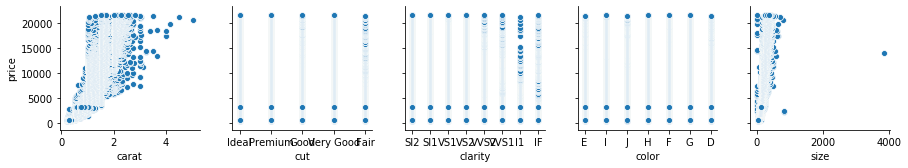

In [75]:
df['size']=df['l']*df['w']*df['d']
sns.pairplot(df, x_vars=['carat', 'cut', 'clarity', 'color', 'size'], y_vars = ['price'])
plt.show()
df.drop(['size'], axis=1, inplace=True)

#### 2. Plot histogram for every feature including price

* Define histplot function

In [76]:
def histplot(df, listvar):
    fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
    counter=0
    for ax in axes:
        df.hist(column=listvar[counter], bins=20, ax=axes[counter])
        plt.ylabel('Price')
        plt.xlabel(listvar[counter])
        counter = counter+1
    plt.show()


* Plot historam for every feature including price

['carat', 'depth', 'table', 'price', 'l', 'w', 'd']

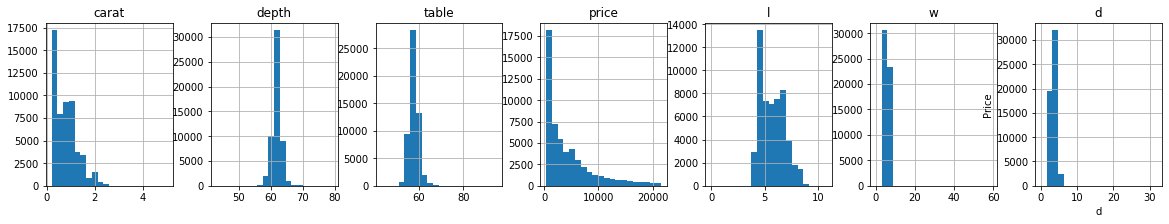

In [77]:
linear_vars = df.select_dtypes(include=[np.number]).columns
display(list(linear_vars))

histplot(df,linear_vars)

#### 3.  
<font color = 'navy'><i><b> 1. Check if any value amongst table, depth, l, w, d is 0
    <br> 2. Add 0.01 to all to make non-zero values  </i></b></font>

In [78]:
print('0 values -->', 0 in df.values)
df[linear_vars] = df[linear_vars] + 0.01
print('Filled all 0 values with 0.01. Now any 0 values? -->', 0 in df.values)

0 values --> True
Filled all 0 values with 0.01. Now any 0 values? --> False


<font color = 'navy'><i><b>3. View outliers</b></i></font>

In [79]:
def sorteddf(df, listvar):
    for var in listvar:
        display('sorted by ' + var + ' --> ' + str(list(df[listvar].sort_values(by=var,ascending=False)[var].head())))

sorteddf(df, linear_vars)      

'sorted by carat --> [5.02, 4.51, 4.14, 4.02, 4.02]'

'sorted by depth --> [79.01, 79.01, 78.21000000000001, 73.61, 72.91000000000001]'

'sorted by table --> [95.01, 79.01, 76.01, 73.01, 73.01]'

'sorted by price --> [21646.459999999995, 21640.709999999995, 21626.909999999996, 21624.609999999997, 21623.459999999995]'

'sorted by l --> [10.75, 10.24, 10.15, 10.03, 10.02]'

'sorted by w --> [58.91, 31.810000000000002, 10.549999999999999, 10.17, 10.11]'

'sorted by d --> [31.810000000000002, 8.07, 6.99, 6.7299999999999995, 6.4399999999999995]'

----> We see that there are some outliers for w,d.
<br>Lets visualise those using boxplots

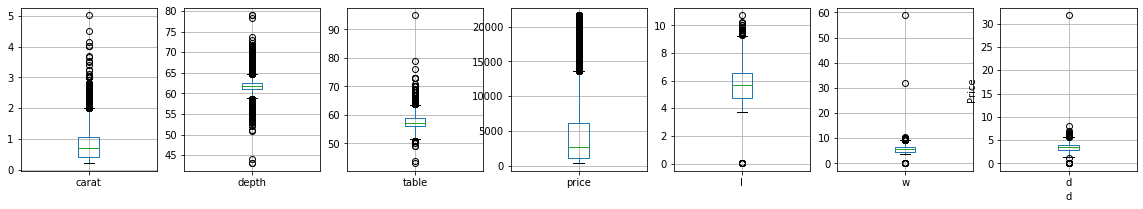

In [80]:
def dfboxplot(df, listvar):
    fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
    counter=0
    for ax in axes:
        df.boxplot(column=listvar[counter], ax=axes[counter])
        plt.ylabel('Price')
        plt.xlabel(listvar[counter])
        counter = counter+1
    plt.show()

dfboxplot(df, linear_vars)


<font color = 'navy'><i><b>Remove outliers using z-score</b></i></font>

53940
53869


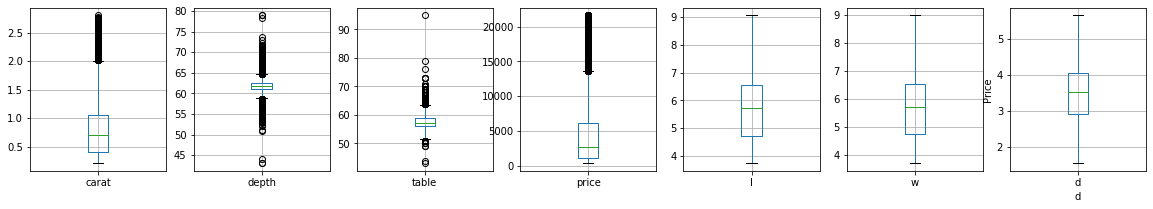

In [81]:
from scipy import stats
# df2=df.copy()

# see length of diamonds dataframe
print(len(df))

df = df[np.abs(stats.zscore(df['d'])) < 3]
df = df[np.abs(stats.zscore(df['w'])) < 3]
df = df[np.abs(stats.zscore(df['l'])) < 3]

# see length of diamonds dataframe with outliers removed
print(len(df))

# view boxplot to confirm removal of outliers
dfboxplot(df, linear_vars)

<font color = 'navy'><i><b>4. Convert to log</b></i></font>

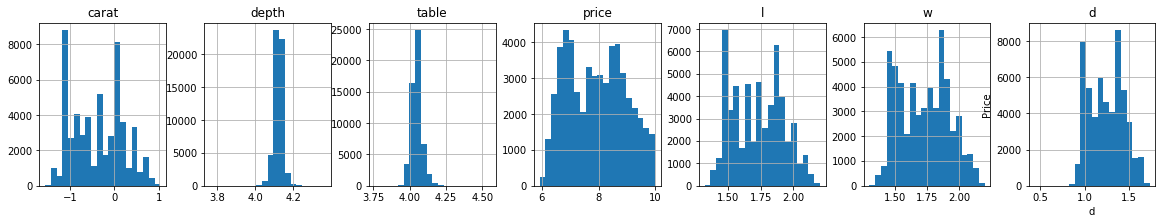

In [82]:
for var in linear_vars:
    df[var] = np.log(df[var])

histplot(df, linear_vars)

# df.head()

#### As expected, the price vs. carat chart is skewed 

In [84]:
# sns.distplot(df['price'])
# plt.show()

#### Since price is not normally distributed, we will log normal it.


In [85]:
## transforming target variable using numpy.log1p
# df['price_log'] = np.log1p(df['price'])

# dist plot again
# sns.distplot(df['price_log'])
# plt.show()

#### Since price is generally quoted as price per carat in Diamond market, lets use that aspect also.

In [ ]:
df['price_pct']=df['price']/df['carat']
sns.pairplot(df, x_vars=['carat', 'cut', 'clarity', 'color'], y_vars = ['price_pct'])
plt.show()
print(df)


In [ ]:
# dist plot again
sns.distplot(df['price_pct'])
plt.show()

In [ ]:
# now drop price_pct
df.drop(['price_pct'], axis=1, inplace=True)

## Data Preprocessing

### 1. Determine mean values of categories of all category columns like cut, clarity and color
* Do a dataframe groupby to find mean. 

* Sort_values sorts result by resulting values, NOT but category label

In [87]:

# Addind a new column in same DF 
# df['price/wt']=df['price']/df['carat']

# IMP: groupby in pandas dataframe
print(df.groupby('cut')['price'].mean().sort_values())
print(df.groupby('color')['price'].mean().sort_values())
print(df.groupby('clarity')['price'].mean().sort_values())

# df = df.drop(['price/wt'], axis=1)


cut
Ideal        7.778507
Very Good    7.937849
Good         7.979939
Premium      8.087666
Fair         8.220433
Name: price, dtype: float64
color
E    7.718592
D    7.755774
F    7.901851
G    7.928158
H    8.055362
I    8.157688
J    8.279947
Name: price, dtype: float64
clarity
VVS1    7.462100
IF      7.544959
VVS2    7.670612
VS1     7.864263
VS2     7.902189
SI1     7.987401
I1      8.115553
SI2     8.302910
Name: price, dtype: float64


### 2. Set X and y now 
* NOTE: two quare brackets [[... ]] are needed to create a datarame. 
* Single [] will create a series / array

In [88]:
X_df = df.drop(['price', 'l', 'w', 'd'], axis=1)
display(X_df.head(3))

y_df = df[['price']] # two [[ to create a DF. Single [] will create a series / array
display(y_df.head(3))

,carat,cut,color,clarity,depth,table
0,-1.427116,Ideal,E,SI2,4.119200,4.007515
1,-1.514128,Premium,E,SI1,4.091173,4.111038
2,-1.427116,Good,E,VS1,4.041471,4.174541


,price
0,5.926686
1,5.926686
2,5.929749


### 3. Convert categorical column to numerical column using labelencoder

In [89]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

def convert_catg(df1):
    
    # Find the columns of object type along with their column index
    object_cols = list(df1.select_dtypes(exclude=[np.number]).columns)
    object_cols_ind = []
    for col in object_cols:
        object_cols_ind.append(df1.columns.get_loc(col))

    # Encode the categorical columns with numbers    
    for i in object_cols_ind:
        df1.iloc[:,i] = le.fit_transform(df1.iloc[:,i])

convert_catg(X_df)
X_df.head(3)



,carat,cut,color,clarity,depth,table
0,-1.427116,2,1,3,4.119200,4.007515
1,-1.514128,3,1,2,4.091173,4.111038
2,-1.427116,1,1,4,4.041471,4.174541


### 4.  Determine correlation between price vs all other attributes.
* seems price is highly corr with carat (and dimensions) and fairly with color and clarity, not much with cut
* combining both X (already converted categorical to numerical) and y to form a new dataframe for correlation

> * **df_le = X_df** --> df_le will be like a pointer to X_df. Any change made to df_le will actually be a change to X_df
> * So, df_le = X_df.**copy()** is better

In [90]:
df_le = X_df.copy()

# add a new column in dataframe - join 2 dataframe columns-wise
df_le['price'] = y_df['price'].values
df_le.corr()


,carat,cut,color,clarity,depth,table,price
carat,1.000000,0.013518,0.259029,-0.231559,0.026325,0.192929,0.966228
cut,0.013518,1.000000,0.001051,0.027190,-0.184979,0.158760,0.024062
color,0.259029,0.001051,1.000000,-0.026550,0.046455,0.026027,0.153636
clarity,-0.231559,0.027190,-0.026550,1.000000,-0.049601,-0.087740,-0.118265
depth,0.026325,-0.184979,0.046455,-0.049601,1.000000,-0.299836,-0.001528
table,0.192929,0.158760,0.026027,-0.087740,-0.299836,1.000000,0.159600
price,0.966228,0.024062,0.153636,-0.118265,-0.001528,0.159600,1.000000


#### How cut is correlated to depth and table
<img src="diam_attr.jpg" alt="Diamond Attributes" style="width: 400px;"/>
https://www.gia.edu/diamond-cut/diamond-cut-anatomy-round-brilliant

* Since IDEAL cut has table and depth values along with crown, pavilion, culet etc in a emperically defined range, viewing the correlation of price with table and depth is of not much use. Nevertheless, its here.

In [91]:
df_le[['cut', 'table', 'depth']].corr()

,cut,table,depth
cut,1.000000,0.158760,-0.184979
table,0.158760,1.000000,-0.299836
depth,-0.184979,-0.299836,1.000000


#### Feature scaling - seems not needed here since we have log1p the price

In [ ]:
'''from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

 
# why fit_transform to X_train whereas transform to X_test?
# Becasue StandardScaler has to be first fitted to X_train. Then StandardScaler will understand data type and wd need only transform
      
X_df = sc_X.fit_transform(X_df)
X_df[0:3]

'''

# Run ML Model


#### train test split

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42)

X_train.head()

,carat,cut,color,clarity,depth,table
35642,-1.139434,2,3,7,4.133726,4.025530
10373,0.148420,3,3,2,4.127296,4.060615
20561,0.444686,4,3,3,4.125682,4.094511
12580,0.190620,4,5,2,4.136925,4.064057
38441,-0.941609,2,1,4,4.128907,4.043227


In [ ]:
# y_test['price'].rename_axis('ID').values

### Linear ML model

In [93]:
from sklearn.linear_model import LinearRegression

reg_all = LinearRegression()
reg_all.fit(X_train,y_train)

y_pred=reg_all.predict(X_test)


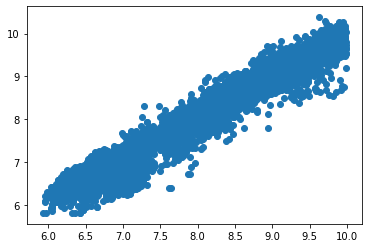

In [94]:
import  matplotlib.pyplot as plt
plt.scatter(y_test,y_pred)

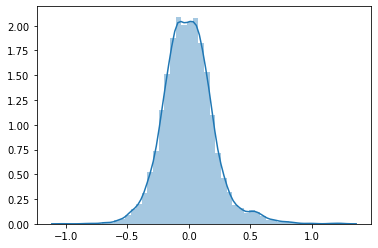

In [95]:
import seaborn as sns
sns.distplot((y_test-y_pred),bins=50);

### Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

In [96]:
from sklearn import metrics

# The following are 

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.15637349900264041
MSE: 0.04254169975210906
RMSE: 0.2062563932393589


### KNN

In [97]:
X_test.head()

,carat,cut,color,clarity,depth,table
19178,0.385262,3,3,3,4.086144,4.077707
19905,0.039221,2,3,6,4.133726,4.043227
15641,0.009950,3,3,5,4.120824,4.060615
24205,0.457425,4,4,2,4.133726,4.060615
14782,0.198851,3,4,2,4.135327,4.060615


In [98]:
from sklearn.neighbors import KNeighborsRegressor

reg_all = KNeighborsRegressor(n_neighbors = 8, metric = 'minkowski', p = 2)
reg_all.fit(X_train,y_train)
y_pred=reg_all.predict(X_test)
y_pred[0:3]


array([[9.11678119],
       [9.18903888],
       [8.81495034]])

In [99]:
y_test.head()

,price
19178,9.118297
19905,9.182158
15641,8.883614
24205,9.564569
14782,8.830574


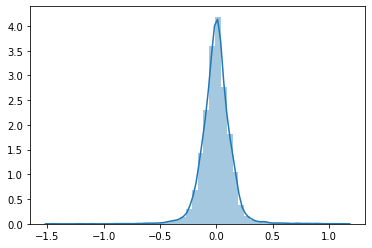

In [100]:
sns.distplot(y_test-y_pred,bins=50)


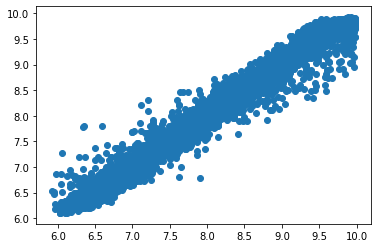

In [101]:
plt.scatter(y_test,y_pred)

In [102]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.09184477188776183
MSE: 0.01771443726810739
RMSE: 0.13309559447294786


#### Now Predict on Pricescope data

In [103]:
ps = pd.read_csv('pricescope.csv')
Xps2 = ps.drop(['Unnamed: 0', 'price'], axis=1)
Xps2.head()

,carat,cut,color,clarity,depth,table
0,0.23,Premium,D,IF,61.5,55
1,0.23,Premium,D,VVS1,61.8,56
2,0.23,Premium,D,VVS1,61.4,55
3,0.23,Premium,D,VVS1,61.5,56
4,0.23,Premium,D,VVS2,61.9,55


In [104]:
yps2 = ps[['price']]
yps2.head()

,price
0,634
1,606
2,646
3,773
4,606


In [105]:
convert_catg(Xps2)

In [106]:
Xps2.head()

,carat,cut,color,clarity,depth,table
0,0.23,0,0,0,61.5,55
1,0.23,0,0,5,61.8,56
2,0.23,0,0,5,61.4,55
3,0.23,0,0,5,61.5,56
4,0.23,0,0,6,61.9,55


In [107]:
y_pred=reg_all.predict(Xps2)
y_pred_exp = np.expm1(y_pred)
y_pred_exp[0:3]
y_pred[0:3]

array([[8.35518307],
       [8.37085915],
       [8.37085915]])

In [108]:
type(y_pred_exp)

numpy.ndarray

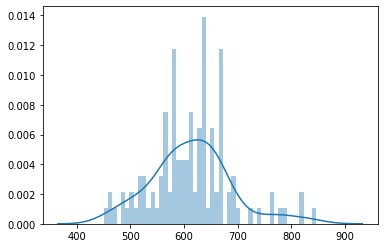

In [109]:
sns.distplot((yps2-y_pred),bins=50)

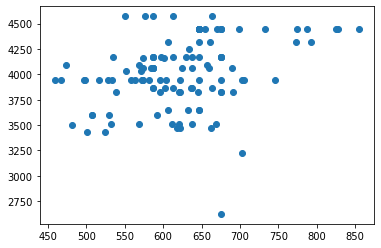

In [110]:
plt.scatter(yps2,y_pred_exp)

### Polynomial regression

In [112]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

reg_all = LinearRegression()
reg_all.fit(X_train_poly,y_train)
y_pred=reg_all.predict(X_test_poly)

In [113]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.1429637364245789
MSE: 0.03494662872240241
RMSE: 0.18694017417987607


### SVM support vector machines


In [114]:
from sklearn.svm import SVR

regressor = SVR(kernel='rbf')
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [115]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.08947356796602714
MSE: 0.013098320106516181
RMSE: 0.11444789253855303


### Random forest

In [ ]:
'''from sklearn.ensemble import RandomForestClassifier
regressor = RandomForestClassifier(n_estimators = 6)
regressor.fit(X_train,Y_train)
y_pred = rf.predict(X_test)
'''

### Neural network

In [116]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.optimizers import RMSprop

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


Using TensorFlow backend.


#### https://keras.io/scikit-learn-api/
#### https://www.programcreek.com/python/example/88638/keras.wrappers.scikit_learn.KerasRegressor
1. construct, compile and return a Keras model, which will then be used to fit/predict.
2. Predict diamond prices
3. ypred vs. ytest now


In [119]:

# define base model
def baseline_model():
    # create model
    model = Sequential()
    # add 1wsst layer
    model.add(Dense(output_dim=3, input_dim=6, kernel_initializer='normal', activation='relu'))
    # add hidden layer
    model.add(Dense(output_dim=3, kernel_initializer='normal', activation='relu'))
    # add output layer
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

'''
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(8,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='relu'))
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error','mean_squared_error'])history = model.fit(X_train,Y_train,batch_size=64,epochs=100,verbose=2)
test=model.evaluate(X_test, Y_test, verbose=1)
'''


"\nmodel = Sequential()\nmodel.add(Dense(256, activation='relu', input_shape=(8,)))\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dense(1, activation='relu'))\nmodel.summary()\nmodel.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error','mean_squared_error'])history = model.fit(X_train,Y_train,batch_size=64,epochs=100,verbose=2)\ntest=model.evaluate(X_test, Y_test, verbose=1)\n"

In [120]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=20, batch_size=5)

kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=6, kernel_initializer="normal", activation="relu", units=3)`
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="normal", activation="relu", units=3)`
  


Epoch 1/20
33937/33937 [==============================] - 5s 145us/step - loss: 2.0696
Epoch 2/20
33937/33937 [==============================] - 5s 143us/step - loss: 0.0509
Epoch 3/20
33937/33937 [==============================] - 5s 138us/step - loss: 0.0507
Epoch 4/20
33937/33937 [==============================] - 5s 139us/step - loss: 0.0507
Epoch 5/20
33937/33937 [==============================] - 5s 143us/step - loss: 0.0506
Epoch 6/20
33937/33937 [==============================] - 5s 138us/step - loss: 0.0504
Epoch 7/20
33937/33937 [==============================] - 5s 134us/step - loss: 0.0506
Epoch 8/20
33937/33937 [==============================] - 5s 142us/step - loss: 0.0504
Epoch 9/20
33937/33937 [==============================] - 5s 136us/step - loss: 0.0503
Epoch 10/20
33937/33937 [==============================] - 5s 139us/step - loss: 0.0505
Epoch 11/20
33937/33937 [==============================] - 5s 136us/step - loss: 0.0502
Epoch 12/20
33937/33937 [================

33937/33937 [==============================] - 5s 153us/step - loss: 0.0505 0s - loss: 0.05
Epoch 12/20
33937/33937 [==============================] - 6s 163us/step - loss: 0.0505
Epoch 13/20
33937/33937 [==============================] - 6s 163us/step - loss: 0.0502
Epoch 14/20
33937/33937 [==============================] - 5s 149us/step - loss: 0.0502
Epoch 15/20
33937/33937 [==============================] - 5s 146us/step - loss: 0.0505
Epoch 16/20
33937/33937 [==============================] - 5s 140us/step - loss: 0.0501
Epoch 17/20
33937/33937 [==============================] - 5s 141us/step - loss: 0.0503
Epoch 18/20
33937/33937 [==============================] - 5s 147us/step - loss: 0.0503
Epoch 19/20
33937/33937 [==============================] - 5s 145us/step - loss: 0.0498
Epoch 20/20
3771/3771 [==============================] - 0s 64us/step
Epoch 1/20
33937/33937 [==============================] - 5s 150us/step - loss: 27.6114
Epoch 2/20
33937/33937 [======================

33938/33938 [==============================] - 5s 145us/step - loss: 27.6640
Epoch 2/20
33938/33938 [==============================] - 5s 152us/step - loss: 1.7832
Epoch 3/20
33938/33938 [==============================] - 5s 152us/step - loss: 1.0338
Epoch 4/20
33938/33938 [==============================] - 5s 148us/step - loss: 1.0337
Epoch 5/20
33938/33938 [==============================] - 5s 144us/step - loss: 1.0336
Epoch 6/20
33938/33938 [==============================] - 5s 143us/step - loss: 1.0339
Epoch 7/20
33938/33938 [==============================] - 5s 144us/step - loss: 1.0338
Epoch 8/20
33938/33938 [==============================] - 5s 142us/step - loss: 1.0337
Epoch 9/20
33938/33938 [==============================] - 5s 144us/step - loss: 1.0338
Epoch 10/20
33938/33938 [==============================] - 5s 147us/step - loss: 1.0337
Epoch 11/20
33938/33938 [==============================] - 5s 145us/step - loss: 1.0337
Epoch 12/20
33938/33938 [==========================

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=6, kernel_initializer="normal", activation="relu", units=3)`
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="normal", activation="relu", units=3)`
  


Epoch 1/20
37708/37708 [==============================] - 5s 140us/step - loss: 2.7329
Epoch 2/20
37708/37708 [==============================] - 5s 144us/step - loss: 0.0501
Epoch 3/20
37708/37708 [==============================] - 5s 134us/step - loss: 0.0498
Epoch 4/20
37708/37708 [==============================] - 5s 137us/step - loss: 0.0500
Epoch 5/20
37708/37708 [==============================] - 6s 146us/step - loss: 0.0499
Epoch 6/20
37708/37708 [==============================] - 5s 137us/step - loss: 0.0498
Epoch 7/20
37708/37708 [==============================] - 5s 137us/step - loss: 0.0498
Epoch 8/20
37708/37708 [==============================] - 6s 148us/step - loss: 0.0498
Epoch 9/20
37708/37708 [==============================] - 6s 153us/step - loss: 0.0496
Epoch 10/20
37708/37708 [==============================] - 5s 133us/step - loss: 0.0497
Epoch 11/20
37708/37708 [==============================] - 5s 129us/step - loss: 0.0495
Epoch 12/20
37708/37708 [================

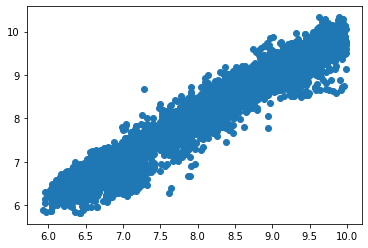

In [121]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
y_pred[0:5]

plt.scatter(y_test,y_pred)
#accuracy_score(y_test, prediction)

#### Now Predict on Pricescope data

In [122]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.1640431956689433
MSE: 0.0468547433599048
RMSE: 0.216459565184597
